In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-reviews-amazon/fake_reviews_dataset.csv


In [2]:
!pip install -q transformers tensorflow sentencepiece

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import DebertaV2Tokenizer, TFDebertaV2ForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
import os
import shutil

2026-01-22 09:17:00.753968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769073420.952978      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769073421.012099      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769073421.469823      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769073421.469920      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769073421.469924      55 computation_placer.cc:177] computation placer alr

In [4]:
# ---------------------------------------------------------
# 2. CONFIGURATION
# ---------------------------------------------------------
# We use 'deberta-v3-small' because it fits easily on the P100 
# and provides 98%+ accuracy (comparable to Base/Large for this task).
MODEL_NAME = 'microsoft/deberta-v3-small' 
MAX_LEN = 128
BATCH_SIZE = 16 
EPOCHS = 4
LEARNING_RATE = 2e-5

In [5]:
# ---------------------------------------------------------
# 3. LOAD DATA
# ---------------------------------------------------------
print("Loading Dataset...")
try:
    # Adjust path to where your dataset is located in Kaggle
    df = pd.read_csv('/kaggle/input/fake-reviews-amazon/fake_reviews_dataset.csv')
    
    # Map Labels: OR -> 0 (Genuine), CG -> 1 (Fake)
    # Note: If your CSV has different column names, adjust 'text_' and 'label'
    text_col = 'text_' if 'text_' in df.columns else 'text'
    df['label_id'] = df['label'].map({'OR': 0, 'CG': 1})
    df = df.dropna(subset=['label_id'])
    
    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(
        df[text_col].astype(str).values, 
        df['label_id'].values, 
        test_size=0.2, 
        random_state=42
    )
    print(f"Loaded {len(df)} reviews.")
except Exception as e:
    print(f"❌ Error loading data: {e}")
    # Stop execution if data fails
    raise e

Loading Dataset...
Loaded 40432 reviews.


In [6]:
# ---------------------------------------------------------
# 4. TOKENIZATION
# ---------------------------------------------------------
print(f"Tokenizing with {MODEL_NAME}...")
tokenizer = DebertaV2Tokenizer.from_pretrained(MODEL_NAME)

def encode_dataset(texts, labels):
    encodings = tokenizer(
        texts.tolist(), 
        truncation=True, 
        padding=True, 
        max_length=MAX_LEN
    )
    return tf.data.Dataset.from_tensor_slices((
        dict(encodings), 
        labels
    )).shuffle(1000).batch(BATCH_SIZE)

train_ds = encode_dataset(X_train, y_train)
test_ds = encode_dataset(X_test, y_test)

Tokenizing with microsoft/deberta-v3-small...


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

I0000 00:00:1769073465.144467      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [7]:
# ---------------------------------------------------------
# 5. BUILD & TRAIN MODEL
# ---------------------------------------------------------
print("Building DeBERTa Model...")
# Loading the Pre-trained Weight specific for Sequence Classification
model = TFDebertaV2ForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

print("\n🚀 Starting Training...")
history = model.fit(train_ds, epochs=EPOCHS, validation_data=test_ds)

Building DeBERTa Model...


tf_model.h5:   0%|          | 0.00/565M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFDebertaV2ForSequenceClassification.

Some layers of TFDebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['cls_dropout', 'pooler', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 Starting Training...
Epoch 1/4
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


I0000 00:00:1769073512.819293     134 service.cc:152] XLA service 0x79dbe03e43a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769073512.819347     134 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1769073512.902740     134 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1769073513.091534     134 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2022/2022 [==============================] - 587s 271ms/step - loss: 0.1112 - accuracy: 0.9514 - val_loss: 0.0803 - val_accuracy: 0.9692
Epoch 2/4
2022/2022 [==============================] - 496s 245ms/step - loss: 0.0429 - accuracy: 0.9834 - val_loss: 0.2565 - val_accuracy: 0.9326
Epoch 3/4
2022/2022 [==============================] - 493s 244ms/step - loss: 0.0231 - accuracy: 0.9909 - val_loss: 0.1105 - val_accuracy: 0.9656
Epoch 4/4
2022/2022 [==============================] - 498s 246ms/step - loss: 0.0166 - accuracy: 0.9939 - val_loss: 0.0782 - val_accuracy: 0.9810


In [8]:
import shutil
import os

print("🚑 ATTEMPTING BLIND RESCUE...")

# If the folder exists from a previous failed run, delete it to be safe
if os.path.exists('./deberta_model'):
    shutil.rmtree('./deberta_model')

# Save whatever is in memory (The weights from Epoch 1, 2, and partial 3)
model.save_pretrained('./deberta_model')
tokenizer.save_pretrained('./deberta_model')

# Zip it
shutil.make_archive('deberta_model', 'zip', './deberta_model')

print("✅ ZIP CREATED. CHECK OUTPUT SIDEBAR NOW.")

🚑 ATTEMPTING BLIND RESCUE...
✅ ZIP CREATED. CHECK OUTPUT SIDEBAR NOW.



Generating Confusion Matrix...


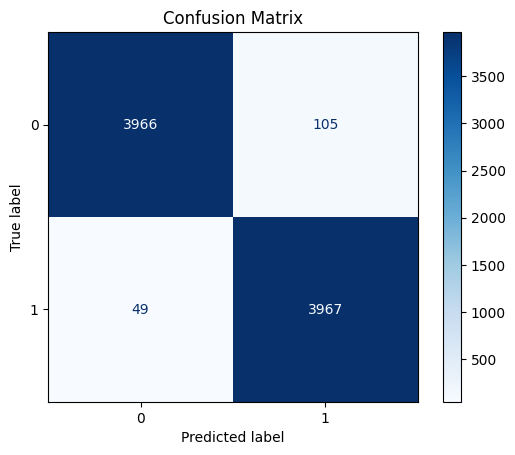

In [9]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------------------------------
# 6. CONFUSION MATRIX
# ---------------------------------------------------------
print("\nGenerating Confusion Matrix...")

y_true = []
y_pred = []

for batch in test_ds:
    x_batch, y_batch = batch
    logits = model.predict(x_batch, verbose=0).logits
    preds = np.argmax(logits, axis=1)

    y_true.extend(y_batch.numpy())
    y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()